# Basic Information

recognition/s45533675/Demo3.ipynb

Requirement: Implement a brain MRI super-resolution network by training on the ADNI brain dataset. Create down-sampled data (approximately by a factor of 4) using Tensorflow implementations. The network should be trained to up-scale from 4x down-sampled input and produce a “reasonably clear image".

# Set Up Environment


In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

TF Version: 2.9.2


# Load data

Download dataset.
I use the built-in keras.utils.get_file utility to retrieve the dataset.

In [2]:
dataset_url = "https://cloudstor.aarnet.edu.au/plus/s/L6bbssKhUoUdTSI/download"
data_dir = keras.utils.get_file(origin=dataset_url, fname="ADNI", extract=True)


185710993/185710993 [==============================] - 11s 0us/step


*   Because this task is not a classification problem, I just use the images in the AD train as my whole dataset.
*   The number of images is 10400 and it completely fits the training requirement.
*   The origin path is ADNI_AD_NC_2D\AD_NC\train\AD and I rename the ADNI_AD_NC_2D to ADNI and newpath is ADNI\AD_NC\train\AD.

In [3]:
root_dir = os.path.join("/root/.keras/datasets/AD_NC/train/AD")

Then I create training and validation datasets via image_dataset_from_directory.

The image size is 256 x 240. The number of images is 10400 so I choose 10% as validation set which is 1040.

# Make train set and valid set

In [4]:
crop_size = 300
upscale_factor = 4
input_size = crop_size // upscale_factor
batch_size = 20

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.1,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.1,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 10400 files belonging to 1 classes.
Using 9360 files for training.
Found 10400 files belonging to 1 classes.
Using 1040 files for validation.


# Pre process images

Normalization

I rescale the images to take values in the range [0, 1].

In [5]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Demonstrate the first batch.

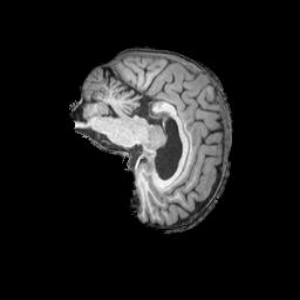

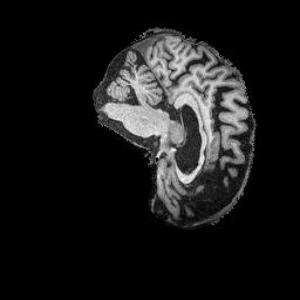

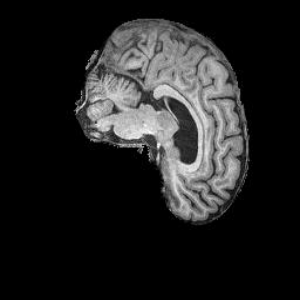

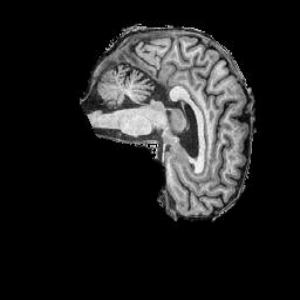

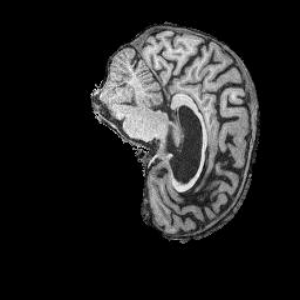

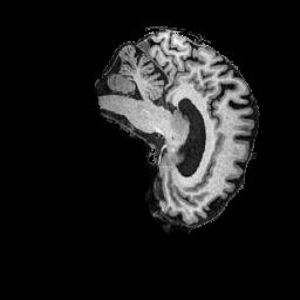

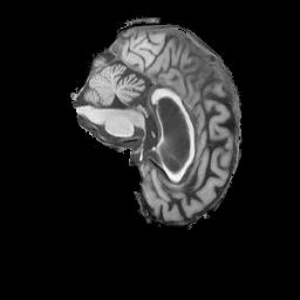

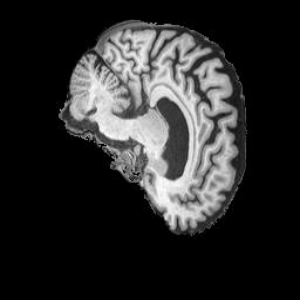

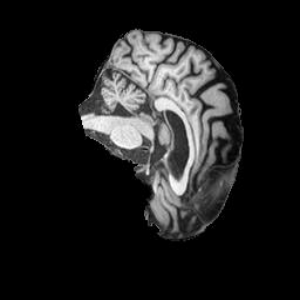

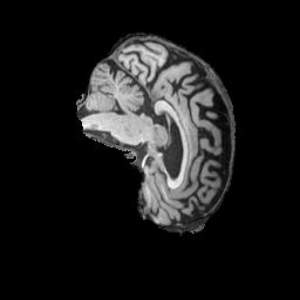

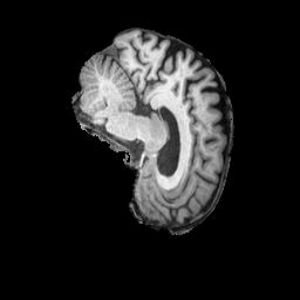

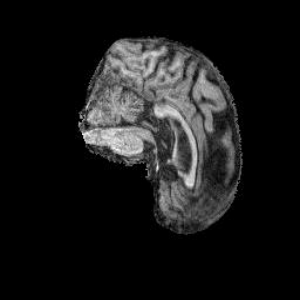

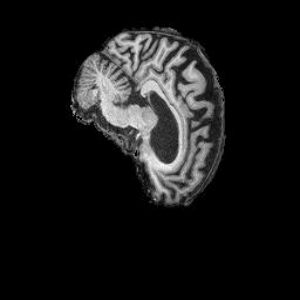

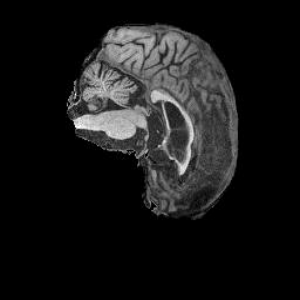

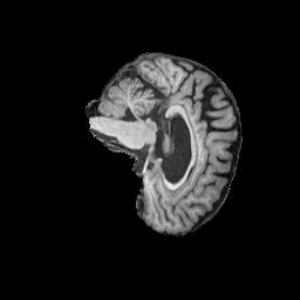

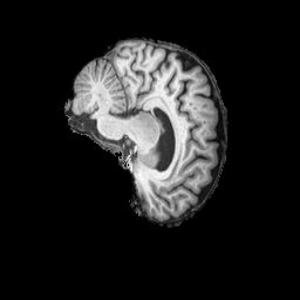

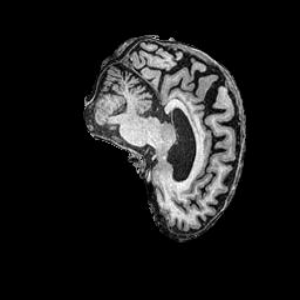

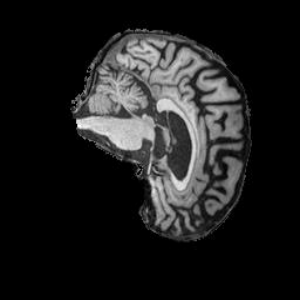

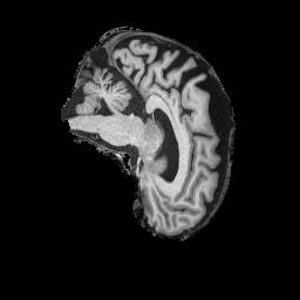

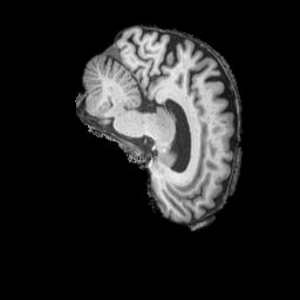

In [6]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

I use images in AD_NC/test/AD as test images for visual evaluation at the end.


In [7]:
test_path = os.path.join("/root/.keras/datasets/AD_NC/test/AD")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpeg")
    ]
)

*   I downsample the original images to low-resolution images, and the original images are high-resolution images.
*   Set low-resolution images to 0 axis, high-resolution images to 1 axis.



In [8]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Show the first processed batch.

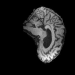

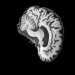

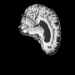

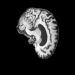

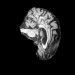

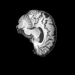

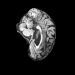

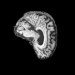

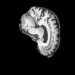

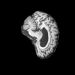

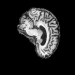

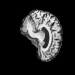

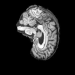

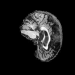

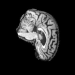

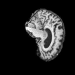

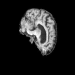

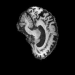

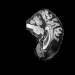

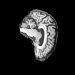

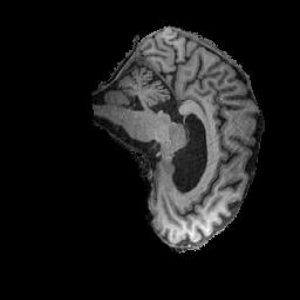

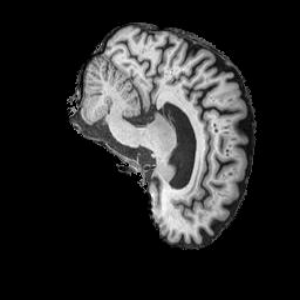

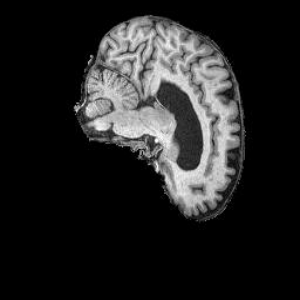

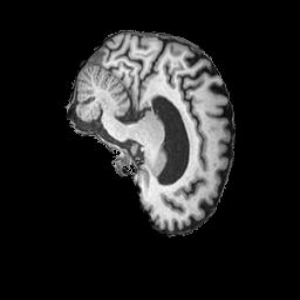

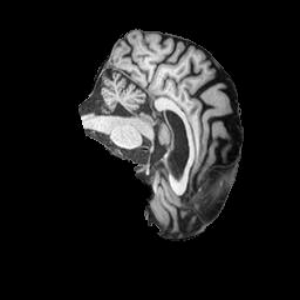

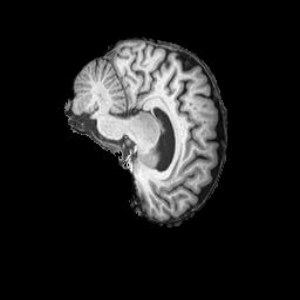

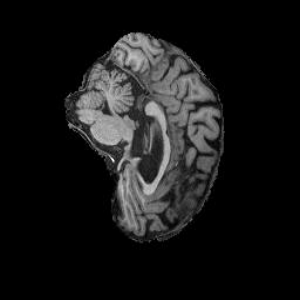

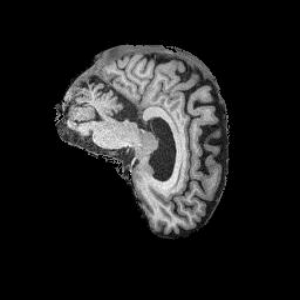

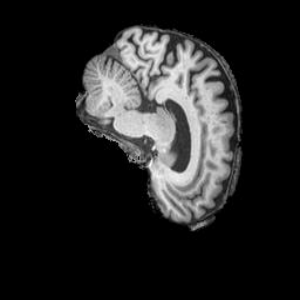

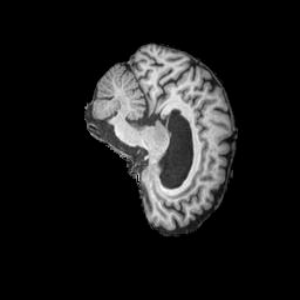

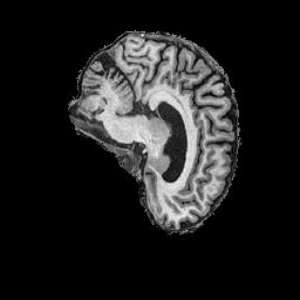

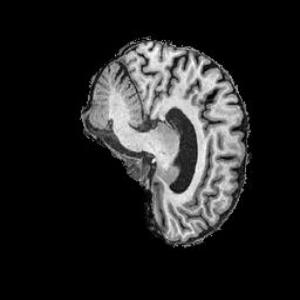

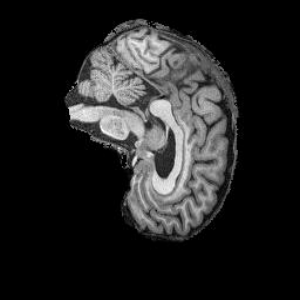

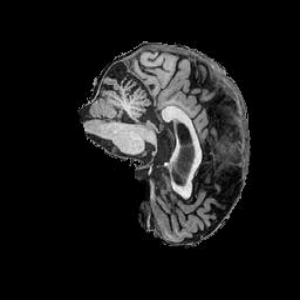

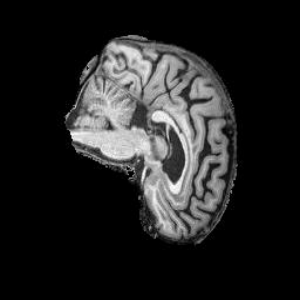

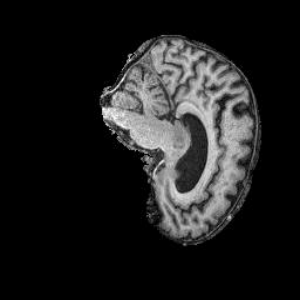

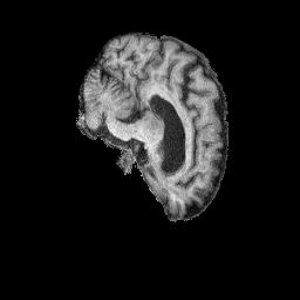

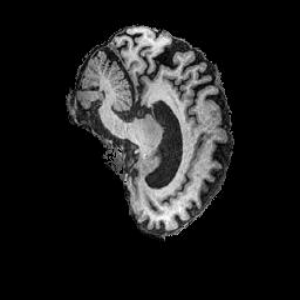

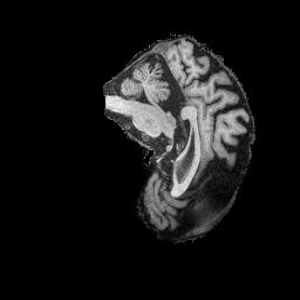

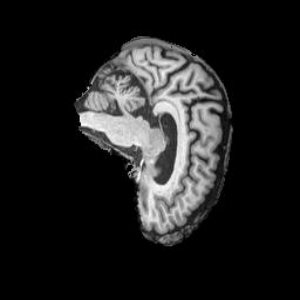

In [9]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

# Build the model

In [17]:
def rdb_block(inputs, numLayers):
    # determine the number of channels present in the current input
    # and initialize a list with the current inputs for concatenation
    channels = inputs.get_shape()[-1]
    storedOutputs = [inputs]
    # iterate through the number of residual dense layers
    for _ in range(numLayers):
        # concatenate the previous outputs and pass it through a
        # CONV layer, and append the output to the ongoing concatenation
        localConcat = tf.concat(storedOutputs, axis=-1)
        out = layers.Conv2D(filters=channels, kernel_size=3, padding="same",
            activation="relu",
            kernel_initializer="Orthogonal")(localConcat)
        storedOutputs.append(out)
    # concatenate all the outputs, pass it through a pointwise
    # convolutional layer, and add the outputs to initial inputs
    finalConcat = tf.concat(storedOutputs, axis=-1)
    finalOut = layers.Conv2D(filters=inputs.get_shape()[-1], kernel_size=1,
        padding="same", activation="relu",
        kernel_initializer="Orthogonal")(finalConcat)
    finalOut = layers.Add()([finalOut, inputs])
    # return the final output
    return finalOut


def get_model(upscale_factor, channels):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(128, 3, **conv_args)(inputs)
    x = layers.Conv2D(128, 3, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 50, 100, 125, 175
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".jpeg")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [12]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [18]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)



In [19]:
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate = 0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 128)   1280      
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 32)    9248

# Train

Epoch 1/300
Mean PSNR for epoch: 20.99
1/1 [==============================] - 0s 77ms/step


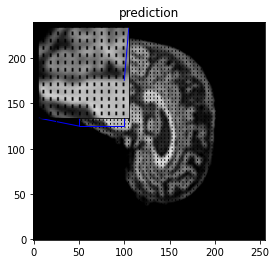

468/468 - 7s - loss: 0.0082 - val_loss: 0.0081 - 7s/epoch - 15ms/step
Epoch 2/300
Mean PSNR for epoch: 20.97
468/468 - 6s - loss: 0.0082 - val_loss: 0.0081 - 6s/epoch - 13ms/step
Epoch 3/300
Mean PSNR for epoch: 21.01
468/468 - 6s - loss: 0.0082 - val_loss: 0.0081 - 6s/epoch - 13ms/step
Epoch 4/300
Mean PSNR for epoch: 20.98
468/468 - 6s - loss: 0.0082 - val_loss: 0.0081 - 6s/epoch - 13ms/step
Epoch 5/300
Mean PSNR for epoch: 23.57
468/468 - 6s - loss: 0.0055 - val_loss: 0.0045 - 6s/epoch - 13ms/step
Epoch 6/300
Mean PSNR for epoch: 23.54
468/468 - 6s - loss: 0.0045 - val_loss: 0.0045 - 6s/epoch - 13ms/step
Epoch 7/300
Mean PSNR for epoch: 23.59
468/468 - 6s - loss: 0.0045 - val_loss: 0.0044 - 6s/epoch - 13ms/step
Epoch 8/300
Mean PSNR for epoch: 23.62
468/468 - 6s - loss: 0.0045 - val_loss: 0.0044 - 6s/epoch - 13ms/step
Epoch 9/300
Mean PSNR for epoch: 23.56
468/468 - 6s - loss: 0.0045 - val_loss: 0.0044 - 6s/epoch - 13ms/step
Epoch 10/300
Mean PSNR for epoch: 23.60
468/468 - 6s - los

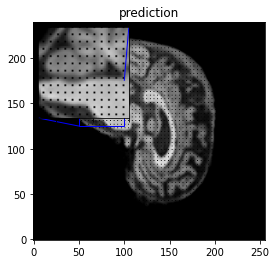

468/468 - 7s - loss: 0.0044 - val_loss: 0.0044 - 7s/epoch - 14ms/step
Epoch 22/300
Mean PSNR for epoch: 23.66
468/468 - 6s - loss: 0.0044 - val_loss: 0.0044 - 6s/epoch - 13ms/step
Epoch 23/300
Mean PSNR for epoch: 23.66
468/468 - 6s - loss: 0.0044 - val_loss: 0.0044 - 6s/epoch - 13ms/step
Epoch 24/300
Mean PSNR for epoch: 23.65
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 25/300
Mean PSNR for epoch: 23.66
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 26/300
Mean PSNR for epoch: 23.70
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 27/300
Mean PSNR for epoch: 23.65
468/468 - 6s - loss: 0.0044 - val_loss: 0.0044 - 6s/epoch - 13ms/step
Epoch 28/300
Mean PSNR for epoch: 23.71
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 29/300
Mean PSNR for epoch: 23.66
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 30/300
Mean PSNR for epoch: 23.66
468/468 - 

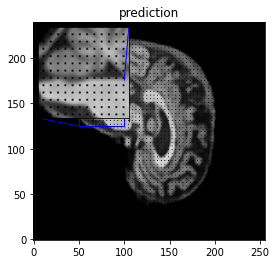

468/468 - 7s - loss: 0.0044 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 42/300
Mean PSNR for epoch: 23.68
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 43/300
Mean PSNR for epoch: 23.70
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 44/300
Mean PSNR for epoch: 23.68
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 45/300
Mean PSNR for epoch: 23.68
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 46/300
Mean PSNR for epoch: 23.69
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 47/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 48/300
Mean PSNR for epoch: 23.70
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 49/300
Mean PSNR for epoch: 23.69
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 50/300
Mean PSNR for epoch: 23.68
468/468 - 

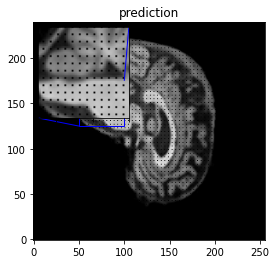

468/468 - 7s - loss: 0.0044 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 62/300
Mean PSNR for epoch: 23.69
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 63/300
Mean PSNR for epoch: 23.71
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 64/300
Mean PSNR for epoch: 23.77
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 65/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 66/300
Mean PSNR for epoch: 23.70
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 67/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 68/300
Mean PSNR for epoch: 23.65
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 69/300
Mean PSNR for epoch: 23.68
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 70/300
Mean PSNR for epoch: 23.71
468/468 - 

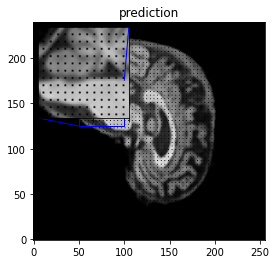

468/468 - 7s - loss: 0.0044 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 82/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 83/300
Mean PSNR for epoch: 23.69
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 84/300
Mean PSNR for epoch: 23.70
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 85/300
Mean PSNR for epoch: 23.68
468/468 - 6s - loss: 0.0044 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 86/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 87/300
Mean PSNR for epoch: 23.70
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 88/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 89/300
Mean PSNR for epoch: 23.70
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 90/300
Mean PSNR for epoch: 23.74
468/468 - 

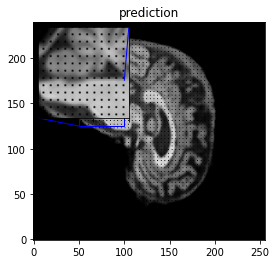

468/468 - 7s - loss: 0.0043 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 102/300
Mean PSNR for epoch: 23.71
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 103/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 104/300
Mean PSNR for epoch: 23.71
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 105/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 106/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 107/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 108/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 109/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 110/300
Mean PSNR for epoch: 23.73
4

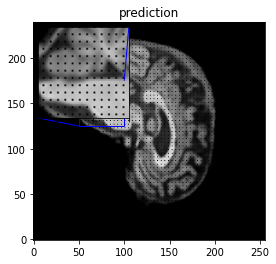

468/468 - 7s - loss: 0.0043 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 122/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 123/300
Mean PSNR for epoch: 23.76
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 124/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 125/300
Mean PSNR for epoch: 23.71
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 126/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 127/300
Mean PSNR for epoch: 23.75
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 128/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 129/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 130/300
Mean PSNR for epoch: 23.73
4

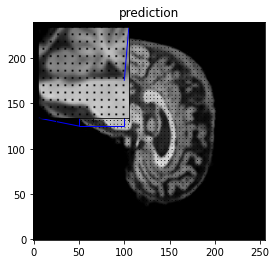

468/468 - 7s - loss: 0.0043 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 142/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 143/300
Mean PSNR for epoch: 23.67
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 144/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 145/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 146/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 147/300
Mean PSNR for epoch: 23.71
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 148/300
Mean PSNR for epoch: 23.75
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 149/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 150/300
Mean PSNR for epoch: 23.74
4

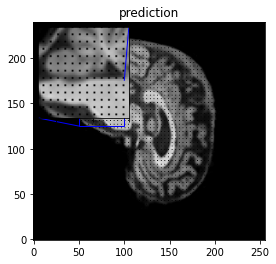

468/468 - 7s - loss: 0.0043 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 162/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 163/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 164/300
Mean PSNR for epoch: 23.75
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 165/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 166/300
Mean PSNR for epoch: 23.76
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 167/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 168/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 169/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 170/300
Mean PSNR for epoch: 23.79
4

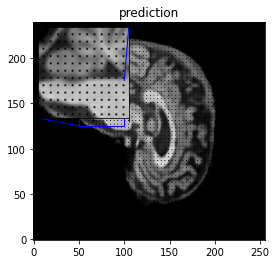

468/468 - 7s - loss: 0.0043 - val_loss: 0.0043 - 7s/epoch - 14ms/step
Epoch 182/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 183/300
Mean PSNR for epoch: 23.75
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 184/300
Mean PSNR for epoch: 23.74
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 185/300
Mean PSNR for epoch: 23.73
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 186/300
Mean PSNR for epoch: 23.78
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 187/300
Mean PSNR for epoch: 23.75
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 188/300
Mean PSNR for epoch: 23.72
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 189/300
Mean PSNR for epoch: 23.71
468/468 - 6s - loss: 0.0043 - val_loss: 0.0043 - 6s/epoch - 13ms/step
Epoch 190/300
Mean PSNR for epoch: 23.77
4

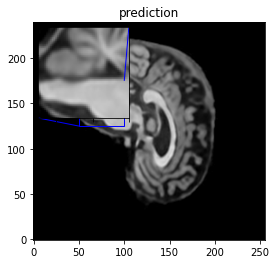

468/468 - 7s - loss: 6.2245e-04 - val_loss: 6.4885e-04 - 7s/epoch - 14ms/step
Epoch 202/300
Mean PSNR for epoch: 31.92
468/468 - 6s - loss: 6.2178e-04 - val_loss: 6.4777e-04 - 6s/epoch - 13ms/step
Epoch 203/300
Mean PSNR for epoch: 31.93
468/468 - 6s - loss: 6.2129e-04 - val_loss: 6.4740e-04 - 6s/epoch - 13ms/step
Epoch 204/300
Mean PSNR for epoch: 31.91
468/468 - 6s - loss: 6.2064e-04 - val_loss: 6.4663e-04 - 6s/epoch - 13ms/step
Epoch 205/300
Mean PSNR for epoch: 31.92
468/468 - 6s - loss: 6.2030e-04 - val_loss: 6.4569e-04 - 6s/epoch - 13ms/step
Epoch 206/300
Mean PSNR for epoch: 31.94
468/468 - 6s - loss: 6.2268e-04 - val_loss: 6.4611e-04 - 6s/epoch - 13ms/step
Epoch 207/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.1707e-04 - val_loss: 6.4564e-04 - 6s/epoch - 13ms/step
Epoch 208/300
Mean PSNR for epoch: 31.89
468/468 - 6s - loss: 6.1818e-04 - val_loss: 6.5003e-04 - 6s/epoch - 13ms/step
Epoch 209/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.1818e-04 - val_loss: 6.45

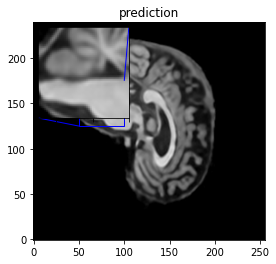

468/468 - 6s - loss: 6.1246e-04 - val_loss: 6.4270e-04 - 6s/epoch - 14ms/step
Epoch 222/300
Mean PSNR for epoch: 31.97
468/468 - 6s - loss: 6.1301e-04 - val_loss: 6.4141e-04 - 6s/epoch - 13ms/step
Epoch 223/300
Mean PSNR for epoch: 31.96
468/468 - 6s - loss: 6.1121e-04 - val_loss: 6.4263e-04 - 6s/epoch - 13ms/step
Epoch 224/300
Mean PSNR for epoch: 31.96
468/468 - 6s - loss: 6.1121e-04 - val_loss: 6.4134e-04 - 6s/epoch - 13ms/step
Epoch 225/300
Mean PSNR for epoch: 31.98
468/468 - 6s - loss: 6.1093e-04 - val_loss: 6.4080e-04 - 6s/epoch - 13ms/step
Epoch 226/300
Mean PSNR for epoch: 31.96
468/468 - 6s - loss: 6.1093e-04 - val_loss: 6.4076e-04 - 6s/epoch - 13ms/step
Epoch 227/300
Mean PSNR for epoch: 31.94
468/468 - 6s - loss: 6.1052e-04 - val_loss: 6.4388e-04 - 6s/epoch - 13ms/step
Epoch 228/300
Mean PSNR for epoch: 31.96
468/468 - 6s - loss: 6.1146e-04 - val_loss: 6.4167e-04 - 6s/epoch - 13ms/step
Epoch 229/300
Epoch 230/300
Mean PSNR for epoch: 31.90
468/468 - 6s - loss: 6.1001e-04 - 

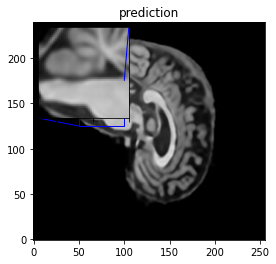

468/468 - 7s - loss: 6.0785e-04 - val_loss: 6.4034e-04 - 7s/epoch - 14ms/step
Epoch 242/300
Mean PSNR for epoch: 31.99
468/468 - 6s - loss: 6.0839e-04 - val_loss: 6.3965e-04 - 6s/epoch - 13ms/step
Epoch 243/300
Mean PSNR for epoch: 31.97
468/468 - 6s - loss: 6.0751e-04 - val_loss: 6.3995e-04 - 6s/epoch - 13ms/step
Epoch 244/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.0749e-04 - val_loss: 6.4011e-04 - 6s/epoch - 13ms/step
Epoch 245/300
Mean PSNR for epoch: 31.86
468/468 - 6s - loss: 6.0775e-04 - val_loss: 6.5437e-04 - 6s/epoch - 13ms/step
Epoch 246/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.0708e-04 - val_loss: 6.4166e-04 - 6s/epoch - 13ms/step
Epoch 247/300
Mean PSNR for epoch: 31.98
468/468 - 6s - loss: 6.0742e-04 - val_loss: 6.3915e-04 - 6s/epoch - 13ms/step
Epoch 248/300
Mean PSNR for epoch: 31.97
468/468 - 6s - loss: 6.0694e-04 - val_loss: 6.3895e-04 - 6s/epoch - 13ms/step
Epoch 249/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.0730e-04 - val_loss: 6.41

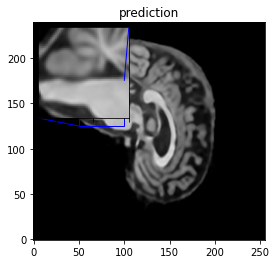

468/468 - 6s - loss: 6.0532e-04 - val_loss: 6.4132e-04 - 6s/epoch - 14ms/step
Epoch 262/300
Mean PSNR for epoch: 32.01
468/468 - 6s - loss: 6.0541e-04 - val_loss: 6.3804e-04 - 6s/epoch - 13ms/step
Epoch 263/300
Mean PSNR for epoch: 31.99
468/468 - 6s - loss: 6.0483e-04 - val_loss: 6.3977e-04 - 6s/epoch - 13ms/step
Epoch 264/300
Mean PSNR for epoch: 31.96
468/468 - 6s - loss: 6.0511e-04 - val_loss: 6.4529e-04 - 6s/epoch - 13ms/step
Epoch 265/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.0427e-04 - val_loss: 6.4039e-04 - 6s/epoch - 13ms/step
Epoch 266/300
Mean PSNR for epoch: 31.96
468/468 - 6s - loss: 6.0476e-04 - val_loss: 6.4141e-04 - 6s/epoch - 13ms/step
Epoch 267/300
Mean PSNR for epoch: 31.96
468/468 - 6s - loss: 6.0467e-04 - val_loss: 6.4076e-04 - 6s/epoch - 13ms/step
Epoch 268/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.0455e-04 - val_loss: 6.3945e-04 - 6s/epoch - 13ms/step
Epoch 269/300
Mean PSNR for epoch: 31.97
468/468 - 6s - loss: 6.0396e-04 - val_loss: 6.39

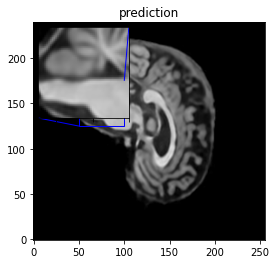

468/468 - 7s - loss: 6.0326e-04 - val_loss: 6.3849e-04 - 7s/epoch - 14ms/step
Epoch 282/300
Mean PSNR for epoch: 31.95
468/468 - 6s - loss: 6.0282e-04 - val_loss: 6.3912e-04 - 6s/epoch - 13ms/step
Epoch 283/300
Mean PSNR for epoch: 31.97
468/468 - 6s - loss: 6.0273e-04 - val_loss: 6.3972e-04 - 6s/epoch - 13ms/step
Epoch 284/300
Mean PSNR for epoch: 31.92
468/468 - 6s - loss: 6.0276e-04 - val_loss: 6.3926e-04 - 6s/epoch - 13ms/step
Epoch 285/300
Mean PSNR for epoch: 31.98
468/468 - 6s - loss: 6.0250e-04 - val_loss: 6.3953e-04 - 6s/epoch - 13ms/step
Epoch 286/300
Mean PSNR for epoch: 31.97
468/468 - 6s - loss: 6.0241e-04 - val_loss: 6.3818e-04 - 6s/epoch - 13ms/step
Epoch 287/300
Mean PSNR for epoch: 31.89
468/468 - 6s - loss: 6.0192e-04 - val_loss: 6.5278e-04 - 6s/epoch - 13ms/step
Epoch 288/300
Mean PSNR for epoch: 31.94
468/468 - 6s - loss: 6.0199e-04 - val_loss: 6.4279e-04 - 6s/epoch - 13ms/step
Epoch 289/300
Mean PSNR for epoch: 31.88
468/468 - 6s - loss: 6.0211e-04 - val_loss: 6.52

In [21]:
epochs = 300

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

# Prediction

If the image is a JPEG (with the extension “. jpg”), it will always be an 8-bit image. Typical values for the PSNR in the lossy image and video compression are between 30 and 50 dB, provided the bit depth is 8 bits, where higher is better.

1/1 [==============================] - 0s 16ms/step
PSNR of low resolution image and high resolution image is 25.3126
PSNR of predict and high resolution is 27.1146


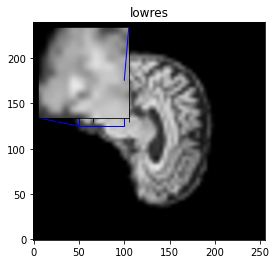

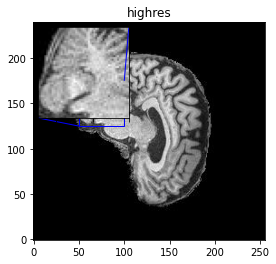

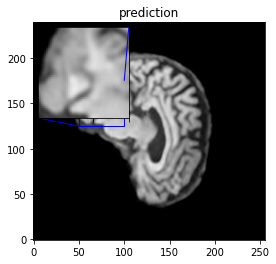

1/1 [==============================] - 0s 18ms/step
PSNR of low resolution image and high resolution image is 25.7794
PSNR of predict and high resolution is 27.5772


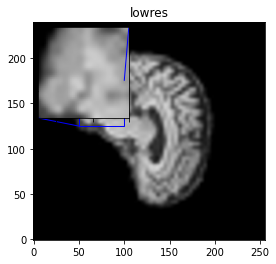

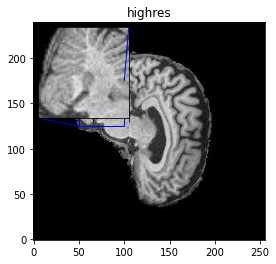

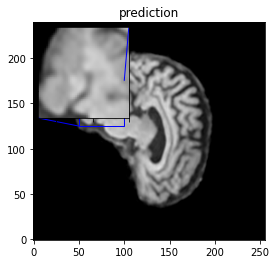

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.1511
PSNR of predict and high resolution is 26.8082


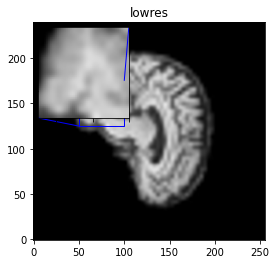

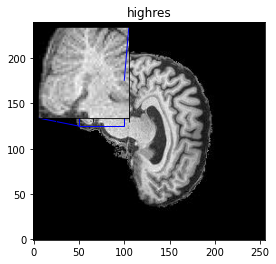

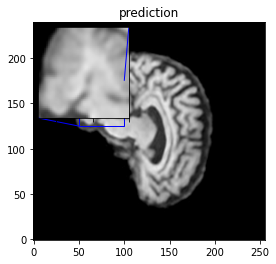

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.3360
PSNR of predict and high resolution is 27.0156


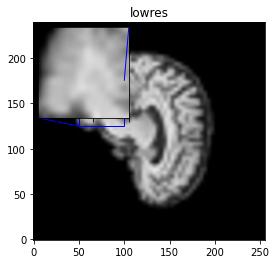

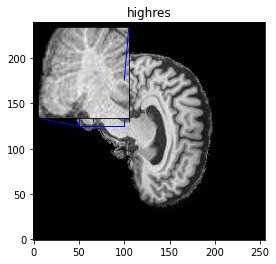

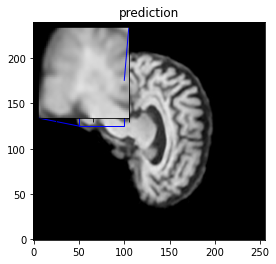

1/1 [==============================] - 0s 19ms/step
PSNR of low resolution image and high resolution image is 25.5713
PSNR of predict and high resolution is 27.0448


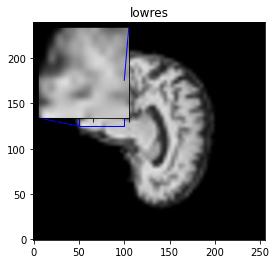

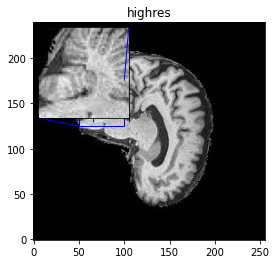

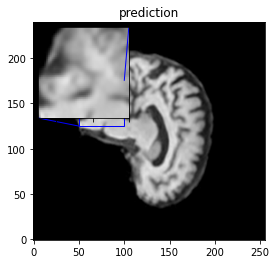

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.6523
PSNR of predict and high resolution is 27.1834


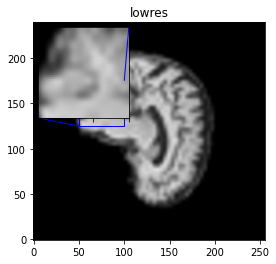

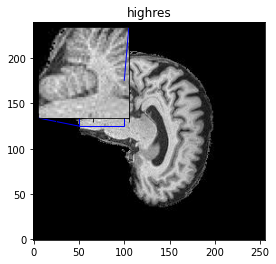

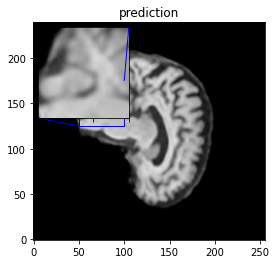

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.4096
PSNR of predict and high resolution is 26.8583


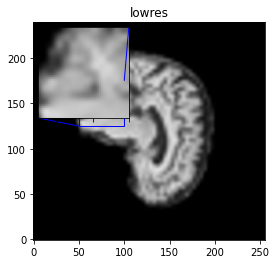

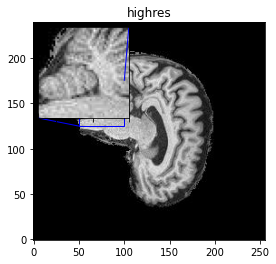

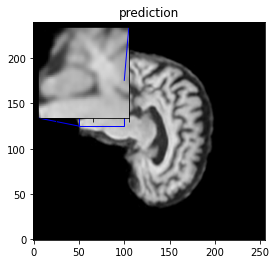

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.4071
PSNR of predict and high resolution is 26.9591


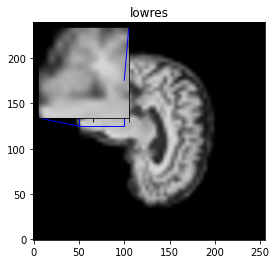

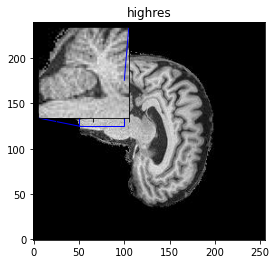

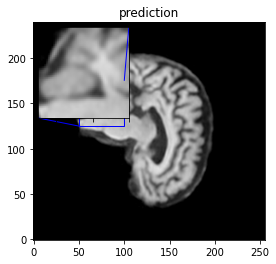

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.0772
PSNR of predict and high resolution is 26.6936


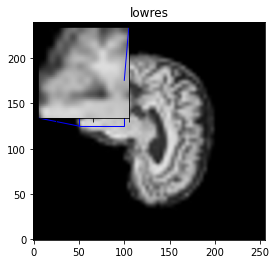

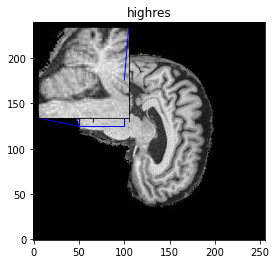

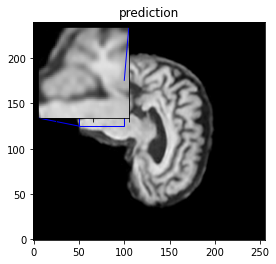

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.2648
PSNR of predict and high resolution is 26.9735


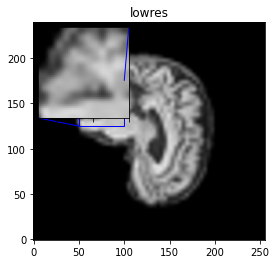

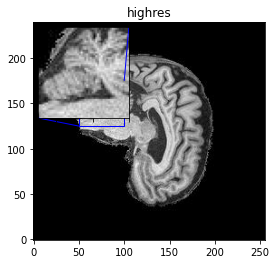

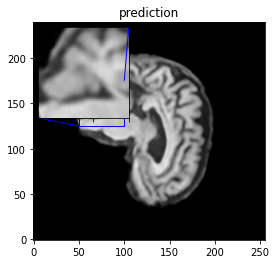

Avg. PSNR of lowres images is 25.3961
Avg. PSNR of reconstructions is 27.0228


In [16]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

Improvement
1. make deeper model
2. change train-valid ratio to 0.1
3. improve the model compile
4. try different batch size
5. try larger crop size
6. draw PSNR graph
7. more epoch
8. loss function

Result
1. more deeper model doesnot better
2. there is no influence whether 0.1 or 0.2 
4. small batch can increase PSNR
5. larger crop size will increase computation costs, decrese the PSNR
